In [23]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from xgboost import XGBRegressor


In [24]:
import optuna

file_path = '../feature_engineered_data.csv'  # <-- แก้เอง

# Use existing df_all in the notebook if available, otherwise read CSV
if 'df_all' in globals():
    df_all_local = df_all.copy()
    print("Using existing df_all from notebook variables")
else:
    df_all_local = pd.read_csv(file_path)
    print(f"Loaded df_all from {file_path}")

# If the dataset is in long format (date_month, ind_code, value) pivot to wide.
# If it's already wide (like the provided cleaned_data2.csv), skip pivot.
if 'ind_code' in df_all_local.columns and 'value' in df_all_local.columns:
    # ensure date column name matches expectation
    if 'date_month' not in df_all_local.columns and 'year_month' in df_all_local.columns:
        df_all_local = df_all_local.rename(columns={'year_month': 'date_month'})
    # ลบ whitespace จาก ind_code
    df_all_local['ind_code'] = df_all_local['ind_code'].astype(str).str.strip()

    print("Available indicators:")
    print(sorted(df_all_local['ind_code'].unique()))
    print()

    df = df_all_local.pivot_table(
        index='date_month',
        columns='ind_code',
        values='value'
    ).reset_index()
else:
    # assume wide format; try to find date column
    if 'date_month' in df_all_local.columns:
        df = df_all_local.copy()
        date_col = 'date_month'
    elif 'year_month' in df_all_local.columns:
        df = df_all_local.copy().rename(columns={'year_month': 'date_month'})
        date_col = 'date_month'
    else:
        raise KeyError("No 'ind_code' column and no recognized date column ('date_month' or 'year_month') found in df_all.")

    print(f"Data treated as wide format. Columns: {sorted(df.columns.tolist())}\n")

print(f"Data loaded: {df.shape}")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month']).sort_index()
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df


Loaded df_all from ../feature_engineered_data.csv
Data treated as wide format. Columns: ['china_pmi', 'china_pmi_lag1', 'china_pmi_lag12', 'china_pmi_lag3', 'china_pmi_lag6', 'china_pmi_ma12', 'china_pmi_ma3', 'china_pmi_ma6', 'china_pmi_std12', 'china_pmi_std3', 'china_pmi_std6', 'date_month', 'domestic_consumption', 'exchange_rate_usd', 'exchange_rate_usd_lag1', 'exchange_rate_usd_lag12', 'exchange_rate_usd_lag3', 'exchange_rate_usd_lag6', 'exchange_rate_usd_pct1', 'exchange_rate_usd_pct12', 'exchange_rate_usd_pct3', 'exchange_rate_usd_pct6', 'export_volume', 'import_volume', 'is_season', 'month', 'net_export', 'net_export_lag1', 'net_export_lag12', 'net_export_lag3', 'net_export_lag6', 'oil_price_thb', 'oil_price_thb_lag1', 'oil_price_thb_lag12', 'oil_price_thb_lag3', 'oil_price_thb_lag6', 'oil_price_thb_ma12', 'oil_price_thb_ma3', 'oil_price_thb_ma6', 'oil_price_thb_pct1', 'oil_price_thb_pct12', 'oil_price_thb_pct3', 'oil_price_thb_pct6', 'oil_price_thb_std12', 'oil_price_thb_std3'

C:\Users\bankw\AppData\Local\Temp\ipykernel_42548\3727405728.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


thai_production  domestic_consumption  import_volume  \
date_month                                                         
2007-01-01        328940000              30652000          55000   
2007-02-01        267868000              26790000          44000   
2007-03-01        246813000              31717000         119000   
2007-04-01        165458000              27788000         184000   
2007-05-01        172153000              32905000          91000   
...                     ...                   ...            ...   
2025-02-01        578922000             109368000          63000   
2025-03-01        413728000              95398000         111000   
2025-04-01        267722000              69306000          73000   
2025-05-01        416062000              90856000         123000   
2025-06-01        339807000              86959000          43000   

            export_volume         stock  exchange_rate_usd  china_pmi  \
date_month                                                              
2007-01-01    267567000.0  2.806710e+08            36.1800       54.8   
2007-02-01    237979000.0  2.490050e+08            35.7500       55.1   
2007-03-01    230410000.0  2.173390e+08            35.0600       53.1   
2007-04-01    180185000.0  1.785750e+08            34.8700       56.1   
2007-05-01    178103000.0  2.092150e+08            34.6200       58.6   
...                   ...           ...                ...        ...   
2025-02-01    369222000.0  1.050152e+09            33.9385       50.2   
2025-03-01    369396000.0  9.991970e+08            33.9768       50.5   
2025-04-01    317716000.0  8.799700e+08            33.9148       49.0   
2025-05-01    360478000.0  8.448210e+08            33.1076       49.5   
2025-06-01    269128000.0  8.285830e+08            32.7844       49.7   

            thai_price  oil_price_thb  world_price_thb_kg  ...  \
date_month                                                 ...   
2007-01-01       65.12    2103.505200           75.168260  ...   
2007-02-01       72.91    2208.992500           81.465325  ...   
2007-03-01       69.62    2309.402200           78.626062  ...   
2007-04-01       72.84    2291.307700           80.907121  ...   
2007-05-01       71.47    2216.026200           82.004049  ...   
...                ...            ...                 ...  ...   
2025-02-01       67.91    2367.549760           82.482469  ...   
2025-03-01       66.56    2428.661664           81.367993  ...   
2025-04-01       59.69    1974.180508           73.920391  ...   
2025-05-01       64.05    2012.611004           73.778769  ...   
2025-06-01       60.94    2134.592284           72.294274  ...   

            supply_demand_balance_lag6  supply_demand_balance_lag12  \
date_month                                                            
2007-01-01                1.099201e+06                 9.458738e+05   
2007-02-01                1.099201e+06                 9.458738e+05   
2007-03-01                1.099201e+06                 9.458738e+05   
2007-04-01                1.099201e+06                 9.458738e+05   
2007-05-01                1.099201e+06                 9.458738e+05   
...                                ...                          ...   
2025-02-01               -5.545600e+07                 2.516900e+07   
2025-03-01                1.950000e+06                -5.163000e+07   
2025-04-01               -2.167300e+07                -5.963100e+07   
2025-05-01               -2.621700e+07                 1.288600e+07   
2025-06-01                1.197610e+08                -1.966500e+07   

            stock_consumption_ratio_lag1  stock_consumption_ratio_lag3  \
date_month                                                               
2007-01-01                     10.272641                     10.266019   
2007-02-01                      9.156695                     10.266019   
2007-03-01                      9.294700                     10.266019   
2007-04-01              

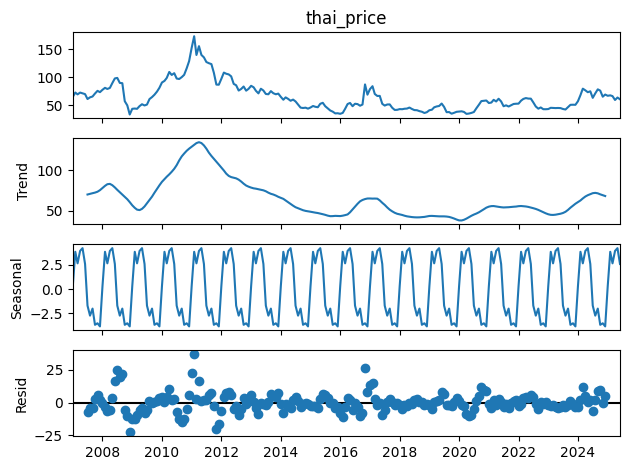

In [25]:
result = seasonal_decompose(df['thai_price'], model='additive', period=12)
result.plot()
plt.show()


Available columns: ['thai_production', 'domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_ma3', 'thai_price_std3', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma3', 'world_price_thb_kg_std3', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma3', 'oil_price_thb_std3', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma3', 'china_pmi_std3', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct1', 'thai_price_pct3', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct1', 'world_price_thb_kg_pct3', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct1', 'oil_price_thb_pct3', 'oil_price_thb_pct6', 'o

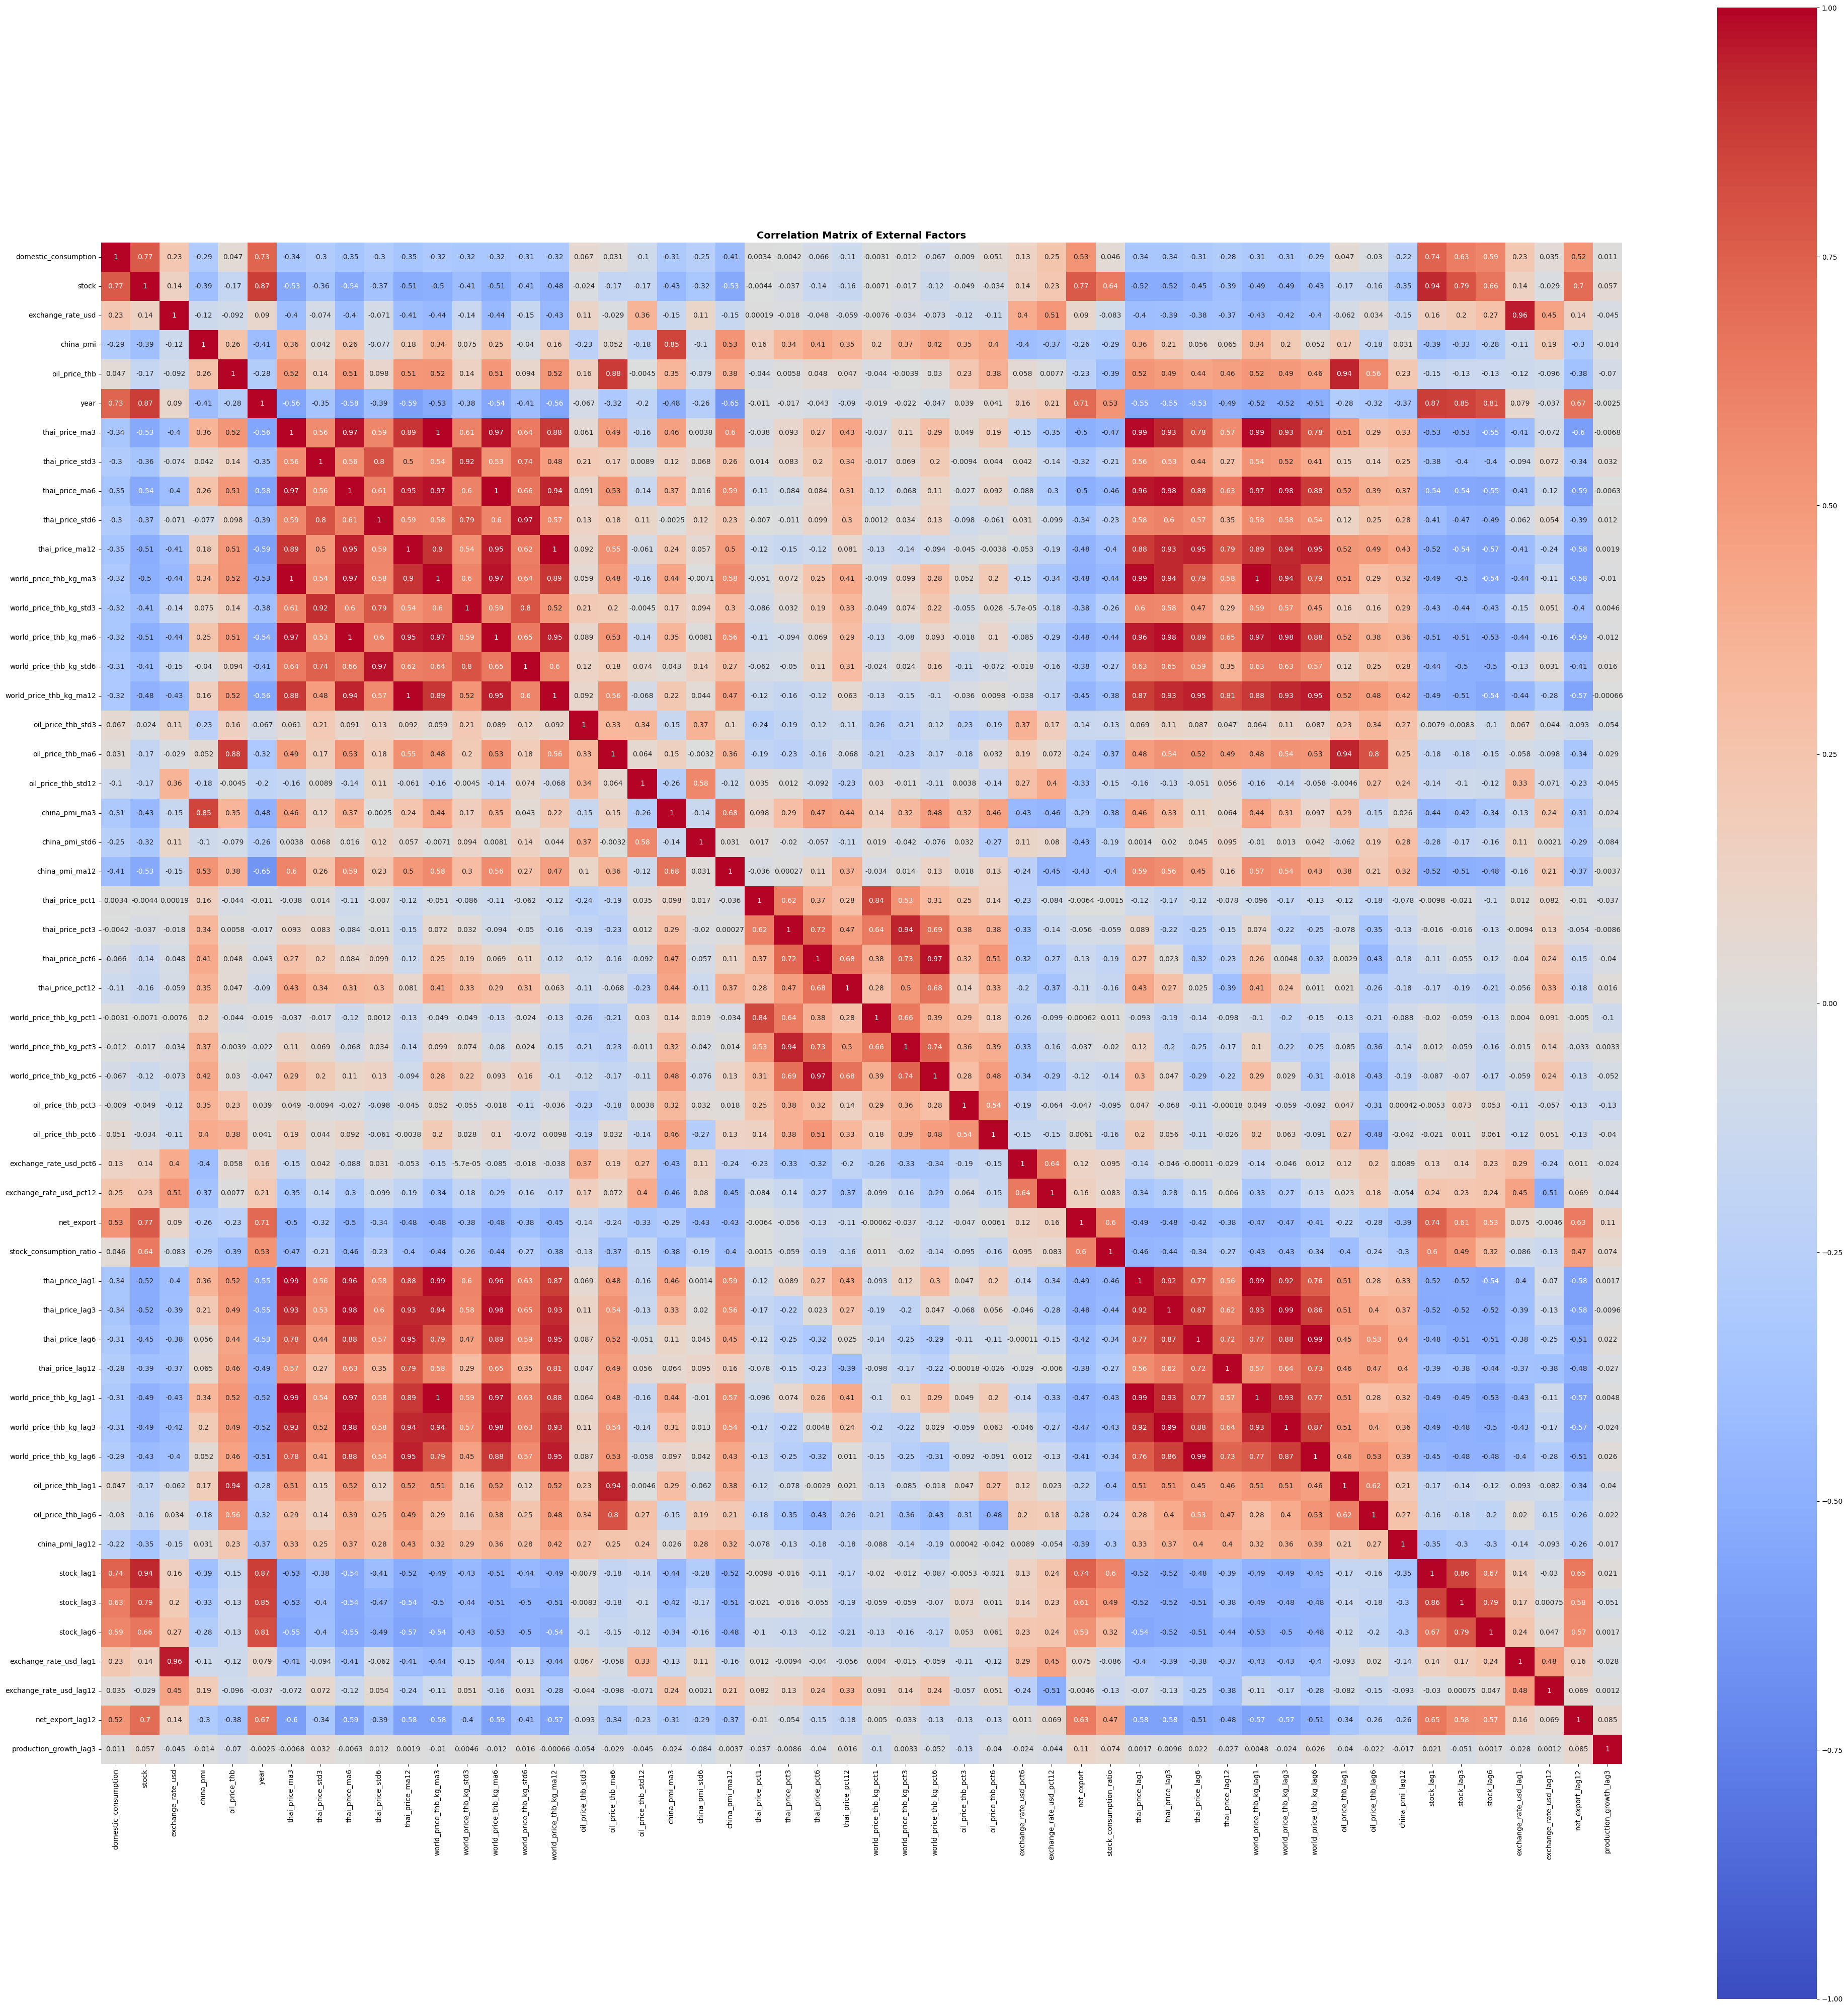

In [26]:
external_factors = [
'domestic_consumption',
'stock',
'exchange_rate_usd',
'china_pmi',
'oil_price_thb',
'year',
'thai_price_ma3',
'thai_price_std3',
'thai_price_ma6',
'thai_price_std6',
'thai_price_ma12',
'world_price_thb_kg_ma3',
'world_price_thb_kg_std3',
'world_price_thb_kg_ma6',
'world_price_thb_kg_std6',
'world_price_thb_kg_ma12',
'oil_price_thb_std3',
'oil_price_thb_ma6',
'oil_price_thb_std12',
'china_pmi_ma3',
'china_pmi_std6',
'china_pmi_ma12',
'thai_price_pct1',
'thai_price_pct3',
'thai_price_pct6',
'thai_price_pct12',
'world_price_thb_kg_pct1',
'world_price_thb_kg_pct3',
'world_price_thb_kg_pct6',
'oil_price_thb_pct3',
'oil_price_thb_pct6',
'exchange_rate_usd_pct6',
'exchange_rate_usd_pct12',
'net_export',
'stock_consumption_ratio',
'thai_price_lag1',
'thai_price_lag3',
'thai_price_lag6',
'thai_price_lag12',
'world_price_thb_kg_lag1',
'world_price_thb_kg_lag3',
'world_price_thb_kg_lag6',
'oil_price_thb_lag1',
'oil_price_thb_lag6',
'china_pmi_lag12',
'stock_lag1',
'stock_lag3',
'stock_lag6',
'exchange_rate_usd_lag1',
'exchange_rate_usd_lag12',
'net_export_lag12',
'production_growth_lag3'
]

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

# เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train = train_exog.copy()
X_test  = test_exog.copy()
y_train = train_data['thai_price']
y_test  = test_data['thai_price']

mean_trp = y_train.mean()
print(f"Mean thai_price (train): {mean_trp:.4f}")
print("X_train:", X_train.shape, " X_test:", X_test.shape)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(40, 40))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [27]:
before_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
before_model.fit(X_train, y_train)
pred_before = before_model.predict(X_test)

rmse_before = np.sqrt(mean_squared_error(y_test, pred_before))
mape_before = mean_absolute_percentage_error(y_test, pred_before)*100

print("=== BEFORE MODEL ===")
print("RMSE:", rmse_before)
print("MAPE:", mape_before)


=== BEFORE MODEL ===
RMSE: 2.7411556811698885
MAPE: 2.9723433847581764


In [28]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10),
        "random_state": 44
    }

    model = XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    return mean_squared_error(y_test, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60)

best_params = study.best_params
print("\nBest Params:",'\n', best_params)


[I 2025-11-27 20:13:29,156] A new study created in memory with name: no-name-7909bcb9-79a0-4120-8bc2-7c49037a9784
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-27 20:13:29,463] Trial 0 finished with value: 3.1283927403380396 and parameters: {'n_estimators': 230, 'learning_rate': 0.060790651400845615, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.045787846719262205, 'subsample': 0.9997718698305679, 'colsample_bytree': 0.6850257836026944, 'reg_alpha': 0.6766373418742397, 'reg_lambda': 4.1877609220274525}. Best is trial 0 with value: 3.1283927403380396.
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove


Best Params: 
 {'n_estimators': 422, 'learning_rate': 0.0530798145706737, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.20105028691564392, 'subsample': 0.44172571040400066, 'colsample_bytree': 0.6365106934192494, 'reg_alpha': 0.7171999651499192, 'reg_lambda': 2.5121433828827247}


In [29]:
after_model = XGBRegressor(
    **best_params, objective='reg:squarederror'
)

after_model.fit(X_train, y_train)
pred_after = after_model.predict(X_test)

rmse_after = np.sqrt(mean_squared_error(y_test, pred_after))
mape_after = mean_absolute_percentage_error(y_test, pred_after)*100

print("=== AFTER MODEL (Optuna) ===")
print("RMSE:", rmse_after)
print("MAPE:", mape_after)


=== AFTER MODEL (Optuna) ===
RMSE: 2.2155106435397838
MAPE: 2.5094620065146422


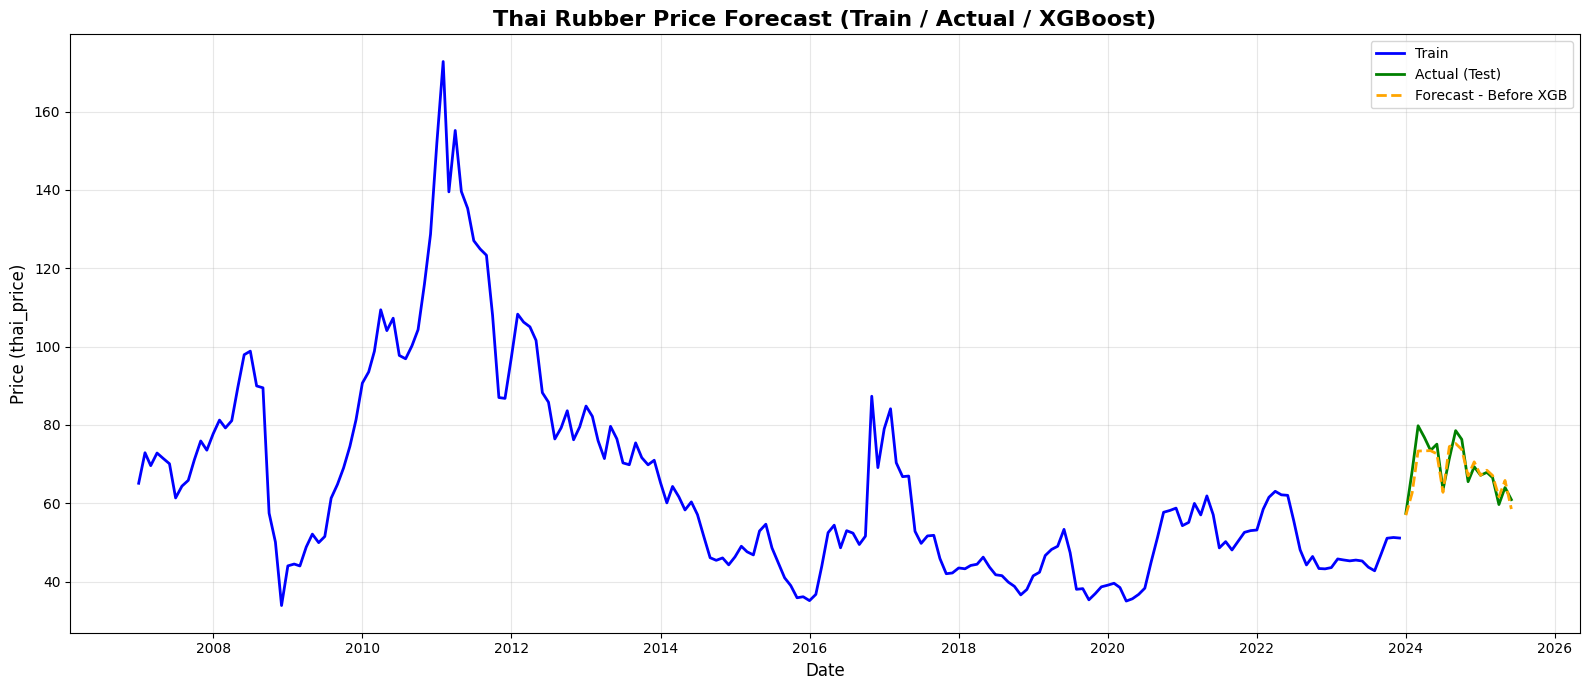

In [30]:
# %%
# Extended visualization 1: Continuous Forecast Plot

plt.figure(figsize=(16, 7))

# เส้น Train ทั้งช่วง
plt.plot(train_data.index,
         train_data['thai_price'],
         label='Train',
         color='blue',
         linewidth=2)

# เส้น Actual ในช่วง Test
plt.plot(test_data.index,
         y_test,
         label='Actual (Test)',
         color='green',
         linewidth=2)

# Forecast แบบ Before (พารามิเตอร์ fix เดิม)
plt.plot(test_data.index,
         pred_before,
         label='Forecast - Before XGB',
         color='orange',
         linestyle='--',
         linewidth=2)

plt.title("Thai Rubber Price Forecast (Train / Actual / XGBoost)",
          fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (thai_price)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


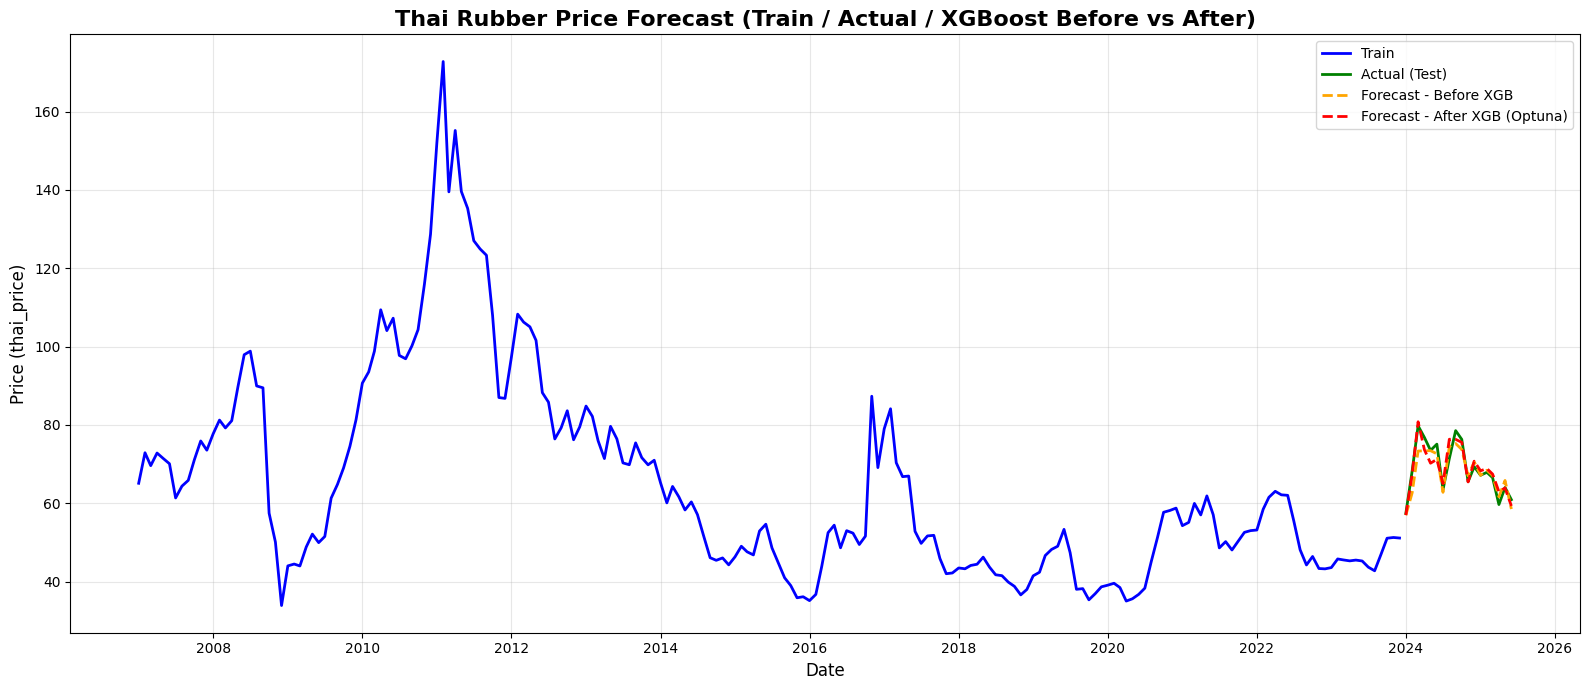

In [31]:
# %%
# Extended visualization 1: Continuous Forecast Plot

plt.figure(figsize=(16, 7))

# เส้น Train ทั้งช่วง
plt.plot(train_data.index,
         train_data['thai_price'],
         label='Train',
         color='blue',
         linewidth=2)

# เส้น Actual ในช่วง Test
plt.plot(test_data.index,
         y_test,
         label='Actual (Test)',
         color='green',
         linewidth=2)

# Forecast แบบ Before (พารามิเตอร์ fix เดิม)
plt.plot(test_data.index,
         pred_before,
         label='Forecast - Before XGB',
         color='orange',
         linestyle='--',
         linewidth=2)

# Forecast แบบ After (Optuna tuned)
plt.plot(test_data.index,
         pred_after,
         label='Forecast - After XGB (Optuna)',
         color='red',
         linestyle='--',
         linewidth=2)

plt.title("Thai Rubber Price Forecast (Train / Actual / XGBoost Before vs After)",
          fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (thai_price)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


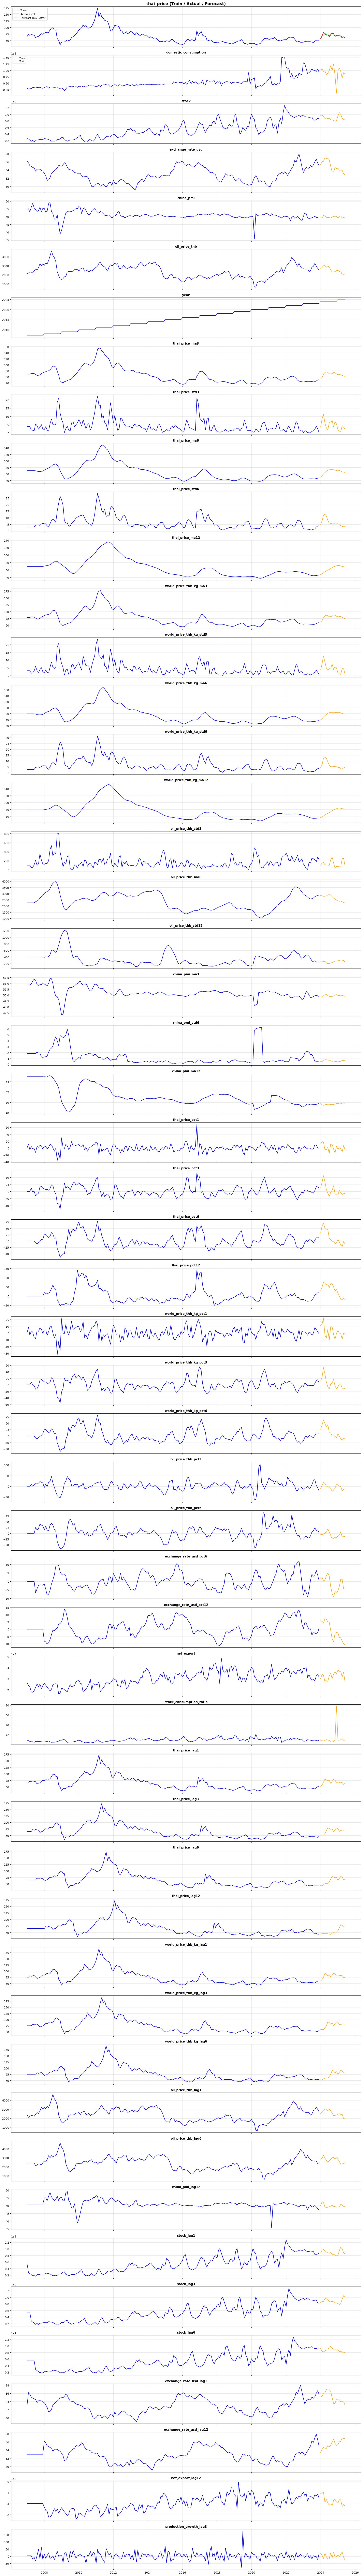

In [32]:
num_factors = len(external_factors)

fig_height = 2.4 * (num_factors + 1)
fig, axes = plt.subplots(
    num_factors + 1, 1,
    figsize=(18, fig_height),
    sharex=True
)

ax0 = axes[0]

ax0.plot(train_data.index,
         train_data['thai_price'],
         label='Train',
         color='blue',
         linewidth=1.8)

ax0.plot(test_data.index,
         y_test,
         label='Actual (Test)',
         color='green',
         linewidth=1.8)

ax0.plot(test_data.index,
         pred_after,
         label='Forecast (XGB After)',
         color='red',
         linestyle='--',
         linewidth=2.0)

ax0.set_title('thai_price (Train / Actual / Forecast)', fontsize=14, fontweight='bold')
ax0.grid(True, alpha=0.3)
ax0.legend(loc='upper left', fontsize=9)

for i, fac in enumerate(external_factors):
    ax = axes[i + 1]

    ax.plot(train_data.index,
            train_data[fac],
            label='Train',
            color='blue',
            linewidth=1.5)

    ax.plot(test_data.index,
            test_data[fac],
            label='Test',
            color='orange',
            linewidth=1.5)

    ax.set_title(f'{fac}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


In [33]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    nrmse = rmse / mean_trp
    mape_norm = mape / 100
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return score

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after, mape_after, mean_trp)

print("\nSCORE")
print("Before:", score_before)
print("After :", score_after)



SCORE
Before: 96.39143062163393
After : 97.029863084036


In [34]:
comparison_df = pd.DataFrame({
    "Model": ["Before (XGBoost)", "After (Optuna XGBoost)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [f"{mape_before:.2f}%", f"{mape_after:.2f}%"],
    "ACCURACY (%)": [f"{score_before:.2f}%", f"{score_after:.2f}%"]
})

print("\nPerformance Comparison\n")
print(comparison_df.to_string(index=False, col_space=15))



Performance Comparison

                 Model            RMSE        MAPE (%)    ACCURACY (%)
      Before (XGBoost)        2.741156           2.97%          96.39%
After (Optuna XGBoost)        2.215511           2.51%          97.03%


In [35]:
print("=== BEFORE MODEL (Baseline XGBOOST)===")
print("RMSE : ",f"{rmse_before:.4f}")
print("MAPE : ",f"{mape_before:.2f}%\n")

=== BEFORE MODEL (Baseline XGBOOST)===
RMSE :  2.7412
MAPE :  2.97%



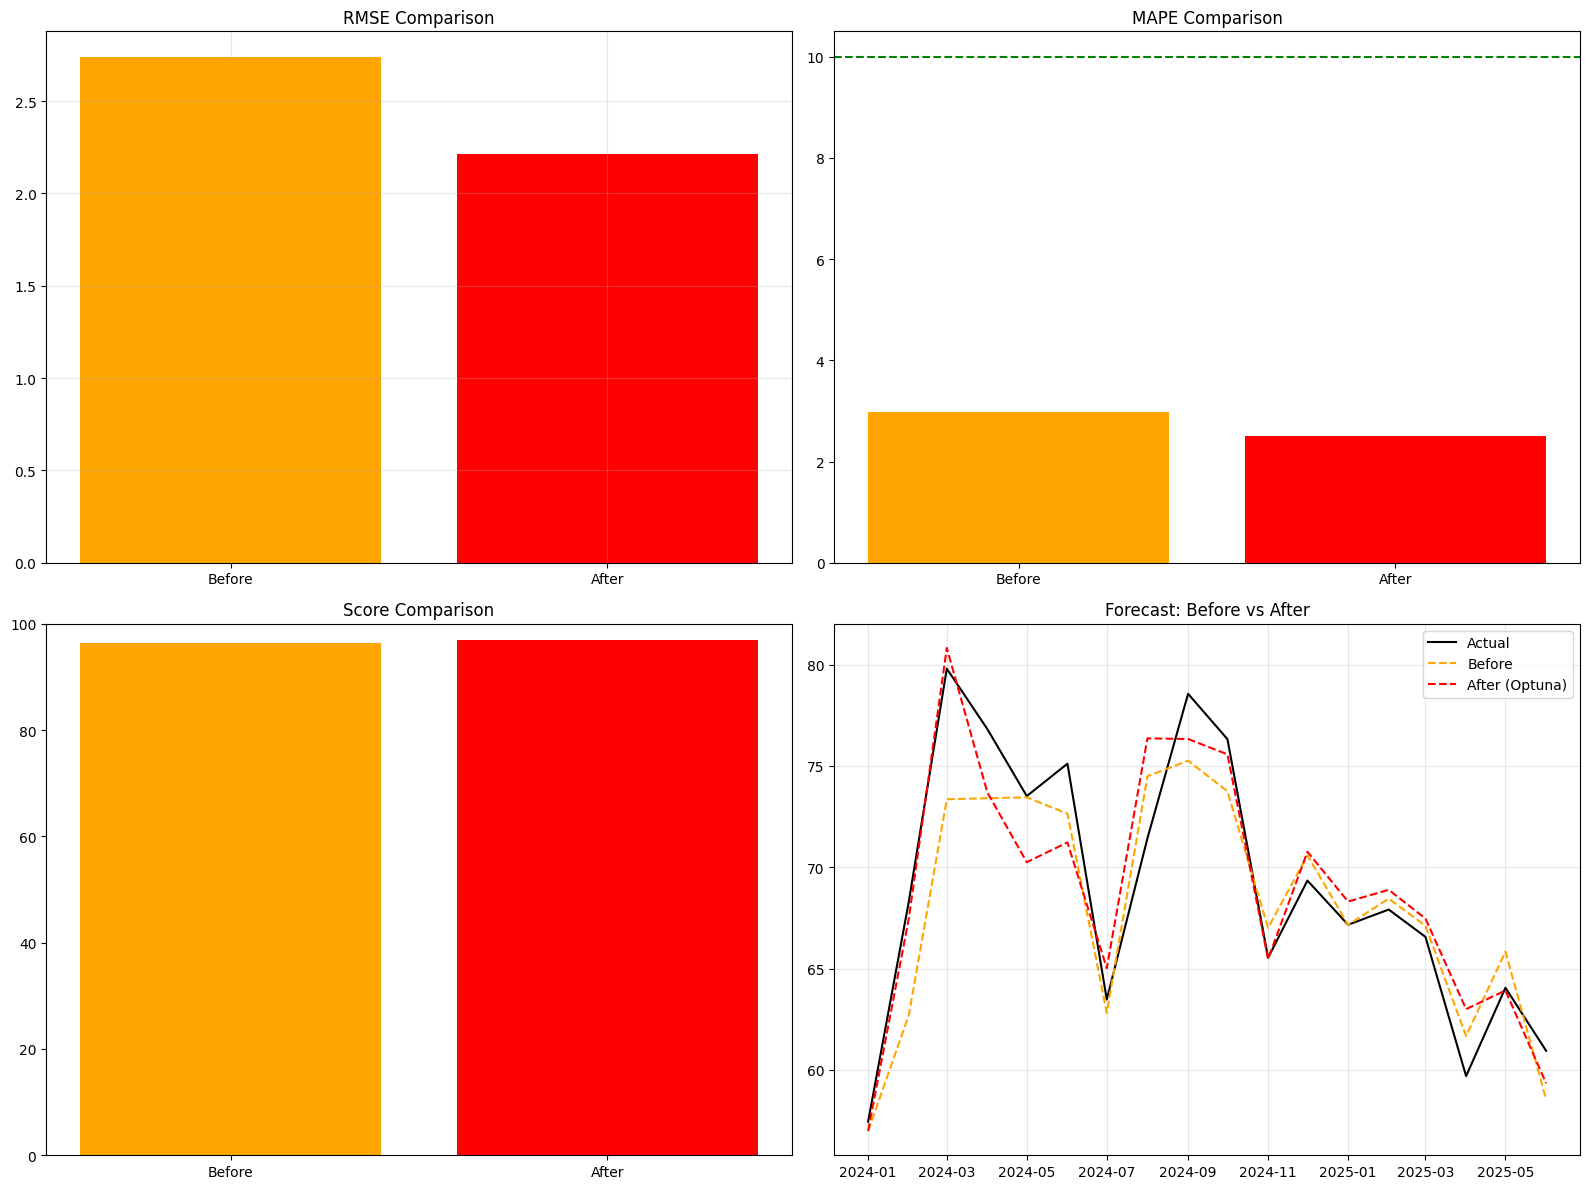

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].bar(["Before", "After"], [rmse_before, rmse_after], color=['orange','red'])
axes[0, 0].set_title("RMSE Comparison")
axes[0, 0].grid(True, alpha=0.3)

# MAPE
axes[0, 1].bar(["Before", "After"], [mape_before, mape_after], color=['orange','red'])
axes[0, 1].set_title("MAPE Comparison")
axes[0, 1].axhline(10, color='green', linestyle='--')

# Score
axes[1, 0].bar(["Before", "After"], [score_before, score_after], color=['orange','red'])
axes[1, 0].set_ylim(0, 100)
axes[1, 0].set_title("Score Comparison")

# Forecast
axes[1, 1].plot(y_test.index, y_test.values, label="Actual", color='black')
axes[1, 1].plot(y_test.index, pred_before, label="Before", linestyle='--', color='orange')
axes[1, 1].plot(y_test.index, pred_after, label="After (Optuna)", linestyle='--', color='red')
axes[1, 1].set_title("Forecast: Before vs After")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


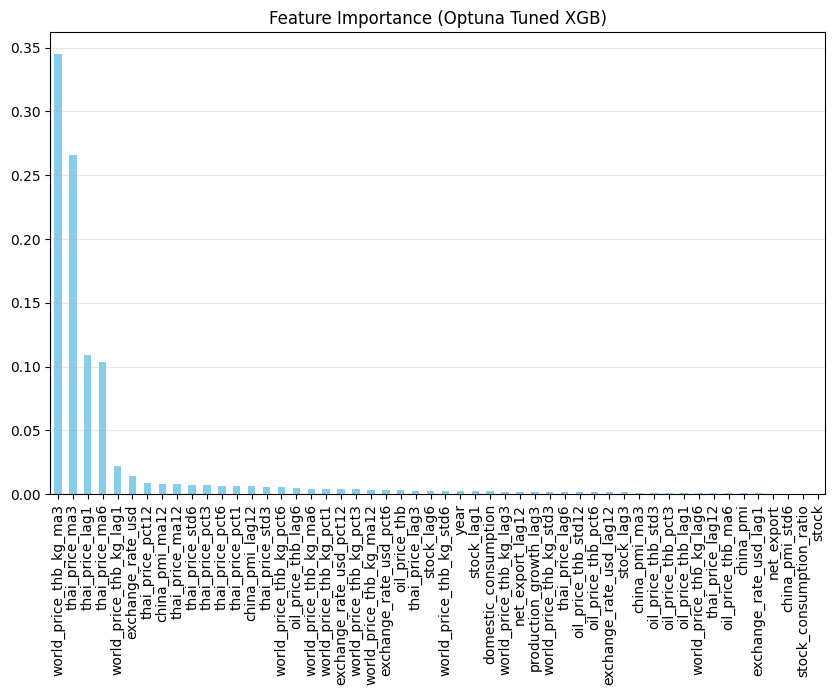

In [37]:
importances = pd.Series(after_model.feature_importances_, index=X_train.columns)\
                .sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance (Optuna Tuned XGB)")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [38]:
data = {
    'Model': ['Before (Fixed XGB)', 'After (Optuna Tuned)'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)
df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison\n")
print(df_display.to_string(index=True, col_space=12))


Performance Comparison

                             Model         RMSE     MAPE (%) ACCURACY (%)
0               Before (Fixed XGB)     2.741156        2.97%       96.39%
1             After (Optuna Tuned)     2.215511        2.51%       97.03%
